<a href="https://colab.research.google.com/github/kurasaiteja/Whatsapp-Analysis/blob/master/Whatsapp_Group_Chat_Analysis_for_iOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whatsapp Group Chat Data Analysis using python.

Hey there! This a project which would keep evolving with time.

A typical data science project would involve 5 steps. The first step is Data Collection. In this case Data collection involves

Opening Whatsapp group chat.
Go to Settings.
Click on Export Chat.
Click on without media.

In [ ]:
!pip install emoji

In [ ]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

In [ ]:
! git clone https://github.com/amueller/word_cloud.git
% cd word_cloud
! pip install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 5773 (delta 33), reused 46 (delta 3), pack-reused 5667
Receiving objects: 100% (5773/5773), 105.93 MiB | 30.99 MiB/s, done.
Resolving deltas: 100% (3368/3368), done.
/content/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud
Processing /content/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post88+ge196d19-cp36-cp36m-linux_x86_64.whl size=338615 sha256=b17002b8dbf6cd3d8f64a74be8903d9fa4bc89043694af984695487c5a964db7
  Stored in directory: /tmp/pip-ephem-wheel-cache-f9ty9i73/wheels/90/f0/1d/23a177aee29f7e3203f94d0d947049c64e5c05296935b2d8ad
Successfully built wordcloud
  Found existing installation: wordcloud 1.6.0.post88+ge196d19
    Uninstalling wordcl

# **Data Preparation:**


This plain text file will have to be parsed and tokenized in a meaningful manner in order to be served (stored) in a Pandas dataframe.

Let us consider just a single line from the text (which we will call “raw text”) and see how we can extract relevant columns from it:

18/06/17, 9:47 PM - Teja: Why do you have 2 numbers?

In our sample line of text, our main objective is to automatically break down the raw message into 4 tokens.

{Date}, {Time} - {Author}: {Message}

{18/06/17}, {9:47 PM} - {Teja}: {Why do you have 2 numbers?}






In [602]:
def startsWithDateAndTime(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])[ ]?(AM|PM|am|pm)?\]'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [603]:
startsWithDateAndTime("[07-03-19 6:46:53] Gowth Bhuj: Ok")

True

In [574]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [604]:
def getDataPoint(line):   
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
      date, time = dateTime.split(',') 
    else:
      date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message


In [632]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/content/_chat.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline()
    fp.readline()
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line: 
            break 
        line = line.strip()
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
          line= (line.encode('ascii', 'ignore')).decode("utf-8")
          if startsWithDateAndTime(line): 
            print(line)
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
          else:
            messageBuffer.append(line)

### If date time is in format Day-Month-year run this code.

In [633]:
import datetime
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = df["Date"].apply(dateconv)
df["Date"] = pd.to_datetime(df["Date"])

[['[07-03-19', '6:45:49', 'Aakarsh', 'Arey'], ['[07-03-19', '6:45:59', 'Aakarsh', 'Adhe chedh aa inka?'], ['[07-03-19', '6:46:15', 'Gowth Bhuj', 'Emaina ideas unte chep'], ['[07-03-19', '6:46:25', 'Aakarsh', 'Gatti competition untadi'], ['[07-03-19', '6:46:41', 'Aakarsh', 'Ipatkipud ante kasht'], ['[07-03-19', '6:46:48', 'Aakarsh', 'Chedh adhe inka']]


In [634]:
df

,Date,Time,Author,Message
0,2019-03-07,6:45:49,Aakarsh,Arey
1,2019-03-07,6:45:59,Aakarsh,Adhe chedh aa inka?
2,2019-03-07,6:46:15,Gowth Bhuj,Emaina ideas unte chep
3,2019-03-07,6:46:25,Aakarsh,Gatti competition untadi
4,2019-03-07,6:46:41,Aakarsh,Ipatkipud ante kasht
5,2019-03-07,6:46:48,Aakarsh,Chedh adhe inka


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37927 entries, 0 to 37926
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     37927 non-null  datetime64[ns]
 1   Time     37927 non-null  object        
 2   Author   37906 non-null  object        
 3   Message  37927 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.2+ MB


## Printing Participants

In [ ]:
df.Author.unique()

array([None, 'Aakarsh', 'Gowtham Bhujam', 'Vishal', 'Saiteja Kura',
       'Manikanta'], dtype=object)

**None** which is the first element in array indicates few messages which do not have authors like,


*   Group was created.
*   Teja was added and so on.



Let us remove the messages created by None

In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37906 entries, 1 to 37926
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     37906 non-null  datetime64[ns]
 1   Time     37906 non-null  object        
 2   Author   37906 non-null  object        
 3   Message  37906 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.4+ MB


In [ ]:
df.Author.unique()

array(['Aakarsh', 'Gowtham Bhujam', 'Vishal', 'Saiteja Kura', 'Manikanta'],
      dtype=object)

We successfully removed None author.

# Group Wise Stats.

In [ ]:
total_messages = df.shape[0]
print(total_messages)

37906


Let us now find out the total Media Messages

In [ ]:
media_messages = df[df['Message'] == 'image omitted'].shape[0]
print(media_messages)

831


In [ ]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

df["emoji"] = df["Message"].apply(split_count)

In [ ]:
emojis = sum(df['emoji'].str.len())
print(emojis)

6596


In [ ]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()


In [ ]:
links = np.sum(df.urlcount)

In [ ]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 37906
Media: 831
Emojis: 6596
Links: 254


## Let us Separate the media messages and text messages and sticker messages

In [ ]:
media_messages_df = df[df['Message'] == 'image omitted']

In [ ]:
sticker_messages_df = df[df['Message'] == 'sticker omitted']
sticker_messages_df

,Date,Time,Author,Message,emoji,urlcount
509,2019-04-13,11:21:24 PM,Manikanta,sticker omitted,[],0
3701,2019-06-19,10:02:39 PM,Gowtham Bhujam,sticker omitted,[],0
4113,2019-06-27,8:16:08 PM,Aakarsh,sticker omitted,[],0
4117,2019-06-27,8:18:33 PM,Vishal,sticker omitted,[],0
4118,2019-06-27,8:18:56 PM,Gowtham Bhujam,sticker omitted,[],0
...,...,...,...,...,...,...
37898,2020-07-10,1:10:38 AM,Manikanta,sticker omitted,[],0
37909,2020-07-10,1:13:46 AM,Gowtham Bhujam,sticker omitted,[],0
37912,2020-07-10,1:14:09 AM,Gowtham Bhujam,sticker omitted,[],0
37915,2020-07-10,1:14:43 AM,Gowtham Bhujam,sticker omitted,[],0


In [ ]:
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(sticker_messages_df.index)

In [ ]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34938 entries, 1 to 37926
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      34938 non-null  datetime64[ns]
 1   Time      34938 non-null  object        
 2   Author    34938 non-null  object        
 3   Message   34938 non-null  object        
 4   emoji     34938 non-null  object        
 5   urlcount  34938 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.9+ MB


It might be interesting to count the number of letters and words used by each author in each message. So, let us add 2 new columns to the data frame called “Letter_Count” and “Word_Count”, using the following code:

In [ ]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [ ]:
messages_df.tail(10)

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount
37916,2020-07-10,1:17:09 AM,Manikanta,https://www.youtube.com/watch?v=8Kmj-2kpzD8,[],1,43,1,1
37917,2020-07-10,1:17:25 AM,Manikanta,"arey e channel vi masth unnai ra, comedy scene...","[😂, 😂]",0,50,10,1
37919,2020-07-10,1:20:27 AM,Manikanta,https://www.youtube.com/watch?v=W3D-rS-H-kU,[],1,43,1,1
37920,2020-07-10,9:20:07 AM,Vishal,Mani memu ni antha posh kaadu,[],0,29,6,1
37921,2020-07-10,9:20:29 AM,Vishal,"Only dubai seenu, venky alantivi chustam",[],0,40,6,1
37922,2020-07-10,10:18:57 AM,Manikanta,Em maatladthunnav ra,[],0,20,3,1
37923,2020-07-10,12:21:01 PM,Saiteja Kura,https://youtu.be/vOj5KLcymgA,[],1,28,1,1
37924,2020-07-10,12:21:11 PM,Saiteja Kura,Must watch!,[],0,11,2,1
37925,2020-07-10,12:23:09 PM,Saiteja Kura,Bathuku gurinchi cheptadu,[],0,25,3,1
37926,2020-07-10,12:33:04 PM,Vishal,Yo chusta,[],0,9,2,1


In [ ]:
messages_df["emojicount"]= df['emoji'].str.len()

#Author wise stats

In [ ]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  #sticker conists of stickers messages
  stickers = sticker_messages_df[sticker_messages_df['Author'] == l[i]].shape[0]
  print('Sticker Messages Sent', stickers)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Aakarsh -
Messages Sent 5674
Words per message 3.804547056750088
Media Messages Sent 193
Sticker Messages Sent 411
Emojis Sent 1370
Links Sent 79

Stats of Gowtham Bhujam -
Messages Sent 6010
Words per message 2.8359400998336106
Media Messages Sent 43
Sticker Messages Sent 784
Emojis Sent 1822
Links Sent 15

Stats of Vishal -
Messages Sent 9740
Words per message 3.3623203285420944
Media Messages Sent 71
Sticker Messages Sent 489
Emojis Sent 1422
Links Sent 55

Stats of Saiteja Kura -
Messages Sent 7940
Words per message 4.012846347607053
Media Messages Sent 343
Sticker Messages Sent 316
Emojis Sent 805
Links Sent 54

Stats of Manikanta -
Messages Sent 5574
Words per message 4.28345891639756
Media Messages Sent 181
Sticker Messages Sent 137
Emojis Sent 1177
Links Sent 51



# Most used Emoji in Group

# Emoji Stats

### Unique emojis used in group

In [ ]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

180


### Most used emoji

In [ ]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 2695), ('🤣', 1436), ('\U0001f97a', 385), ('😒', 212), ('🔥', 79), ('🙄', 78), ('😞', 64), ('\U0001f973', 61), ('🤦🏻\u200d♂', 59), ('🤕', 53), ('🤙🏻', 46), ('😮', 45), ('😪', 44), ('🙂', 44), ('😭', 43), ('😢', 43), ('🤧', 40), ('🤦🏻\u200d♂️', 39), ('😅', 35), ('😨', 34), ('😕', 34), ('😔', 34), ('😏', 32), ('🙃', 29), ('😎', 29), ('😱', 28), ('\U0001f975', 26), ('🤥', 26), ('🤢', 23), ('🙏', 23), ('☹️', 23), ('💥', 23), ('\U0001f92f', 22), ('\U0001f928', 20), ('😖', 19), ('👏🏻', 18), ('😣', 18), ('😆', 18), ('😑', 17), ('🙏🏻', 17), ('😁', 16), ('😟', 16), ('👍🏻', 16), ('😳', 15), ('🤷🏻\u200d♂', 14), ('🍃', 14), ('\U0001f974', 13), ('😲', 13), ('\U0001f929', 11), ('🍻', 11), ('\U0001f971', 11), ('😤', 10), ('🕺🏻', 10), ('\U0001f970', 10), ('😍', 10), ('🤷🏻\u200d♂️', 10), ('😐', 9), ('😓', 9), ('😴', 9), ('🤔', 8), ('👀', 8), ('\U0001f92e', 8), ('👍', 8), ('\U0001f9d0', 8), ('😦', 8), ('\U0001f92d', 7), ('🤐', 7), ('😶', 7), ('😬', 7), ('😡', 7), ('👗', 7), ('😵', 7), ('🙁', 7), ('💯', 7), ('🙆🏻\u200d♂', 6), ('😹', 6), ('😇', 6), ('\U0001f9b

In [ ]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,2695
1,🤣,1436
2,🥺,385
3,😒,212
4,🔥,79
...,...,...
175,😗,1
176,🍀,1
177,👈,1
178,🖕🏻,1


We can see '😂 '   dominates the list.

### Emoji distribution visualisation

In [ ]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Person Wise Emoji Distribution

In [ ]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Aakarsh


Emoji Distribution for Gowtham Bhujam


Emoji Distribution for Vishal


Emoji Distribution for Saiteja Kura


Emoji Distribution for Manikanta


# Some more Stats

### **Day wise Distribution**

In [ ]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [ ]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

### **Number of messages as times move on**

In [ ]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

### **Chatter**

In [ ]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

### **When are the group members most active?**

Text(0, 0.5, 'Time')

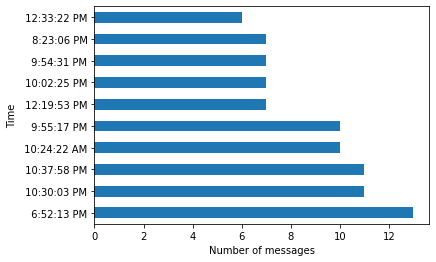

In [ ]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

### **The most happening day was -**

2019-07-26    725
2020-06-26    469
2020-04-06    438
2019-08-18    434
2019-08-12    410
             ... 
2019-09-24      1
2019-04-15      1
2020-03-03      1
2019-05-01      1
2019-09-09      1
Name: Date, Length: 392, dtype: int64


Text(0, 0.5, 'Date')

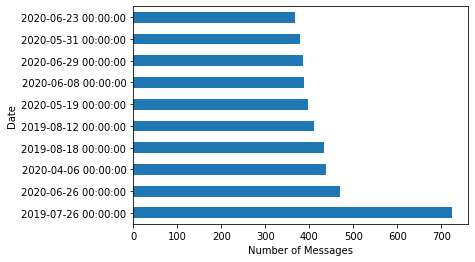

In [ ]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

### **The early bird**

### The Late Owl

### **Message Having Maximum number of words**

In [ ]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2020-03-19 00:00:00
Time                                                  11:03:00 AM
Author                                                    Aakarsh
Message         *Since, you are working from home, forwarding ...
emoji                                                          []
urlcount                                                       30
Letter_Count                                                 4906
Word_Count                                                    592
MessageCount                                                    1
emojicount                                                      0
Name: 17426, dtype: object

### **Word Cloud**

In [ ]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 751986 words in all the messages.


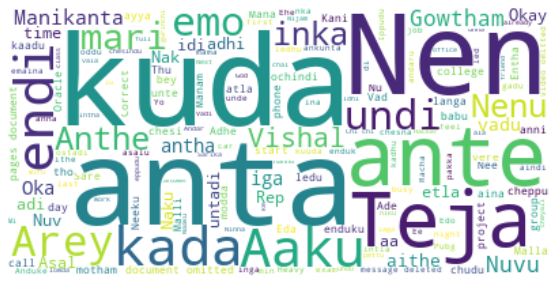

In [ ]:
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","Ma","Haa","ni"])
  # Generate a word cloud image
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

Author name Aakarsh


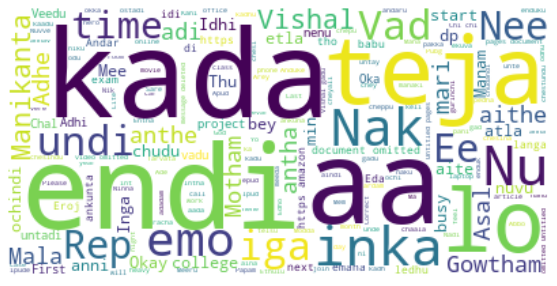

Author name Gowtham Bhujam


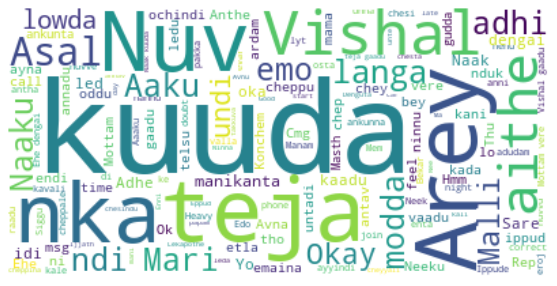

Author name Vishal


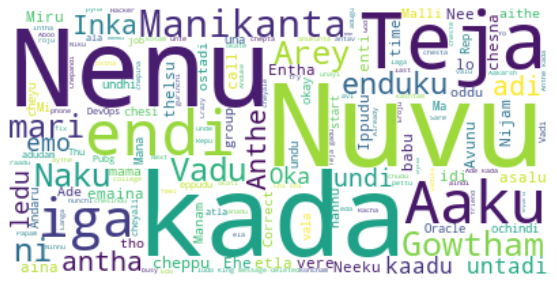

Author name Saiteja Kura


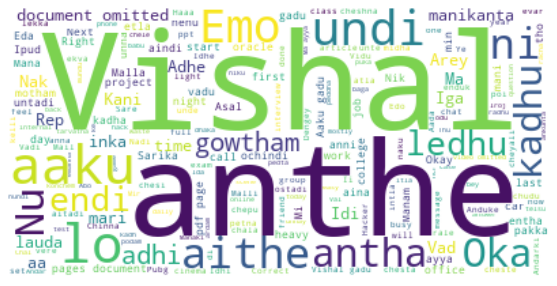

Author name Manikanta


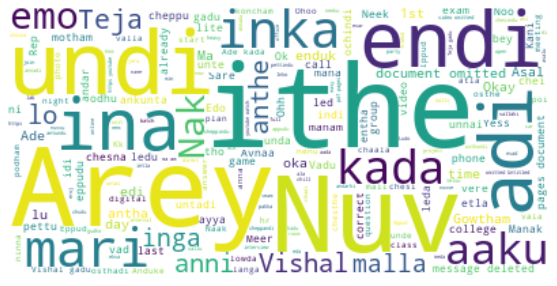

In [ ]:
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  text = " ".join(review for review in dummy_df.Message)
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","anta","kuda","ante","la","eh","Nen","ne","haa","Haa","le"])
  # Generate a word cloud image
  print('Author name',l[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
""

''